Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting CNN image classification experiments
GPU is available! Using CUDA: Tesla T4

Running experiment for CIFAR dataset

************ Start ************
Loading data...
loading data...
Loaded 50000 training instances and 10000 testing instances
train_X shape: (50000, 32, 32, 3), train_y shape: (50000,)
test_X shape: (10000, 32, 32, 3), test_y shape: (10000,)
Training and testing the model...
method running...
--start training...
Epoch 1/100, Loss: 1.3402, Accuracy: 0.5179
Epoch 10/100, Loss: 0.6550, Accuracy: 0.7724
Epoch 20/100, Loss: 0.5312, Accuracy: 0.8165
Epoch 30/100, Loss: 0.4760, Accuracy: 0.8349
Epoch 40/100, Loss: 0.4447, Accuracy: 0.8445
Epoch 50/100, Loss: 0.4266, Accuracy: 0.8543
Epoch 60/100, Loss: 0.4115, Accuracy: 0.8588
Epoch 70/100, Loss: 0.3953, Accuracy: 0.8633
Epoch 80/100, Loss: 0.3878, Accuracy: 0.8663
Epoch 90/100, Loss: 0.3829, Acc

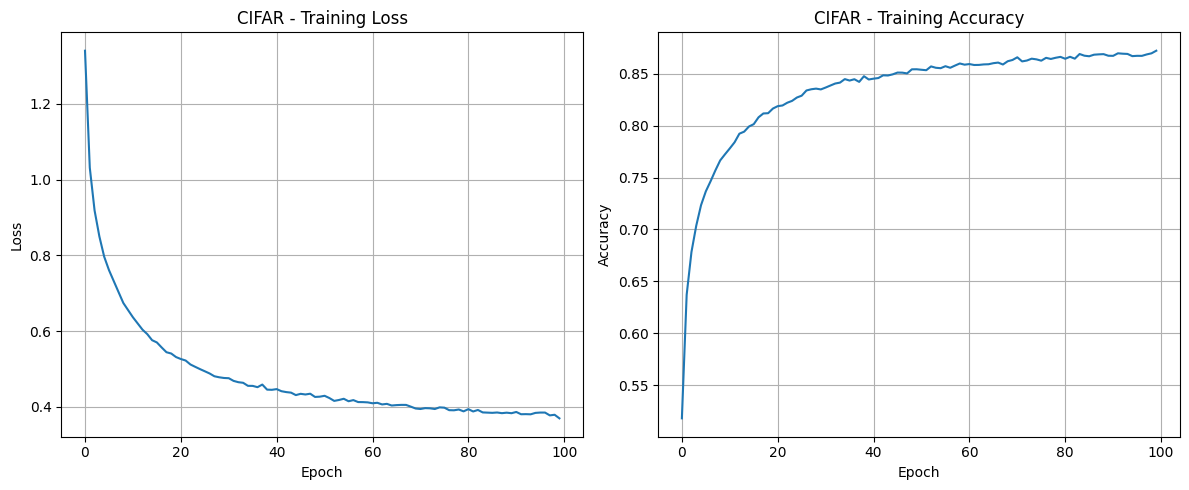

************ Finish ************

All experiments (potentially only CIFAR) completed!


Results Summary:
--------------------------------------------------
MNIST Test Accuracy: 0.0000
ORL Test Accuracy: 0.0000
CIFAR Test Accuracy: 0.8540
--------------------------------------------------


In [8]:
# Colab setup script for running CNN experiments

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn
from torchvision import transforms # <<< NEW
from torch.utils.data import Dataset, DataLoader # <<< NEW

# Define the base classes
class method:
    def __init__(self, mName, mDescription):
        self.mName = mName
        self.mDescription = mDescription

class dataset:
    def __init__(self, dName, dDescription):
        self.dName = dName
        self.dDescription = dDescription

class result:
    pass

class evaluate:
    pass

# Define the Dataset Loader
class Dataset_Loader(dataset):
    data = None
    dataset_source_folder_path = None
    dataset_source_file_name = None

    def __init__(self, dName=None, dDescription=None):
        super().__init__(dName, dDescription)

    def load(self):
        print('loading data...')
        # Ensure the path is correct for your Drive structure
        # Example: '/content/drive/My Drive/Colab Notebooks/datasets/'
        # Or if 'CIFAR' is directly in 'My Drive':
        # self.dataset_source_folder_path = '/content/drive/My Drive/'
        # self.dataset_source_file_name = 'CIFAR' # This should be the actual file name, e.g., 'cifar-10-batches-py/data_batch_1' or your preprocessed pickle file

        # Assuming dataset_source_file_name is the full name of the pickle file like 'CIFAR.pkl' or just 'CIFAR' if that's the filename
        file_path = os.path.join(self.dataset_source_folder_path, self.dataset_source_file_name)

        # If your pickle file is just named 'CIFAR' (no extension)
        # and it's directly in 'My Drive':
        # file_path = '/content/drive/My Drive/CIFAR'

        with open(file_path, 'rb') as f: # <<< MODIFIED to use os.path.join for clarity
            loaded_data = pickle.load(f, encoding='latin1') # <<< Added encoding for Python 3 if pickle was from Python 2 (common for CIFAR pickles)

        train_X, train_y, test_X, test_y = [], [], [], []

        # --- CIFAR-10 Pickle Structure Specific Loading ---
        # This part needs to be adapted if your 'CIFAR' pickle file structure is different.
        # The original code assumed a dict with 'train' and 'test' keys, each a list of dicts.
        # Standard CIFAR-10 pickles are different.
        # Let's assume your 'CIFAR' pickle IS structured as loaded_data['train'] and loaded_data['test']
        # where each contains {'image': ..., 'label': ...}

        if self.dataset_source_file_name == 'CIFAR_original_format': # Example for standard CIFAR-10 batches
            # This is a placeholder: you'd typically load multiple batches for CIFAR train
            # and the test_batch for test.
            # For simplicity, let's assume 'loaded_data' is already in your {'train': [{'image':img, 'label':lbl}, ...], 'test': ...} format
            pass # Keep your existing loop if your pickle is already in the expected format


        for instance in loaded_data['train']:
            image = instance['image']
            if self.dataset_source_file_name == 'ORL': # Keep ORL specific logic if needed elsewhere
                image = image[:, :, 0]
            # For CIFAR, images are often HWC, 0-255. Normalization to 0-1 is good.
            # The ToTensor transform later will handle CHW conversion if image is HWC numpy.
            image = image / 255.0
            train_X.append(image)
            train_y.append(instance['label'])

        for instance in loaded_data['test']:
            image = instance['image']
            if self.dataset_source_file_name == 'ORL':
                image = image[:, :, 0]
            image = image / 255.0
            test_X.append(image)
            test_y.append(instance['label'])

        # Convert to NumPy arrays. Ensure correct shapes.
        # For CIFAR, train_X would be (num_samples, 32, 32, 3) if loaded HWC
        train_X = np.array(train_X, dtype=np.float32)
        train_y = np.array(train_y)
        test_X = np.array(test_X, dtype=np.float32)
        test_y = np.array(test_y)

        print(f'Loaded {len(train_X)} training instances and {len(test_X)} testing instances')
        print(f'train_X shape: {train_X.shape}, train_y shape: {train_y.shape}')
        print(f'test_X shape: {test_X.shape}, test_y shape: {test_y.shape}')

        return {'train': {'X': train_X, 'y': train_y},
                'test': {'X': test_X, 'y': test_y}}

# <<< NEW Custom Dataset Class for PyTorch DataLoader and Transforms
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # Expected to be numpy array (N, H, W, C) for CIFAR
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] # This is (H, W, C)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image) # Transform should handle ToTensor for CHW

        return image, label

# Define the CNN Method
class Method_CNN(method, nn.Module):
    data = None
    max_epoch = 100
    learning_rate = 1e-3
    batch_size = 64
    dataset_name = 'MNIST'
    weight_decay = 1e-4 # <<< NEW: L2 Regularization factor

    def __init__(self, mName, mDescription, dataset_name='MNIST'):
        method.__init__(self, mName, mDescription)
        nn.Module.__init__(self)
        self.dataset_name = dataset_name

        # <<< NEW: Define transforms here or pass them in
        if dataset_name == 'CIFAR':
            # CIFAR-10 specific means and stds for normalization
            cifar_mean = [0.4914, 0.4822, 0.4465]
            cifar_std = [0.2023, 0.1994, 0.2010]
            self.train_transform = transforms.Compose([
                transforms.ToTensor(), # Converts numpy HWC [0,1] to tensor CHW [0,1]
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize(cifar_mean, cifar_std)
            ])
            self.test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(cifar_mean, cifar_std)
            ])
        else: # Default/MNIST transforms (assuming grayscale, HWC or HW, normalized to 0-1 by loader)
            self.train_transform = transforms.Compose([
                transforms.ToTensor(), # Converts numpy HW [0,1] to tensor CHW [0,1] (C=1)
                # Add other MNIST specific transforms if needed
                transforms.Normalize((0.1307,), (0.3081,)) # MNIST specific
            ])
            self.test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)) # MNIST specific
            ])


        if dataset_name == 'MNIST':
            self.input_channels = 1
            self.input_height = 28
            self.input_width = 28
            self.num_classes = 10
            self.conv_layers = nn.Sequential(
                nn.Conv2d(self.input_channels, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            conv_output_height = self.input_height // 4
            conv_output_width = self.input_width // 4
            conv_output_size = conv_output_height * conv_output_width * 64
            self.fc_layers = nn.Sequential(
                nn.Linear(conv_output_size, 128),
                nn.BatchNorm1d(128), # <<< MODIFIED
                nn.ReLU(),
                nn.Dropout(0.5), # Dropout is good, keep it
                nn.Linear(128, self.num_classes)
            )
        elif dataset_name == 'ORL':
            self.input_channels = 1
            self.input_height = 112
            self.input_width = 92
            self.num_classes = 40
            self.conv_layers = nn.Sequential(
                nn.Conv2d(self.input_channels, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            conv_output_height = self.input_height // 8
            conv_output_width = self.input_width // 8
            conv_output_size = conv_output_height * conv_output_width * 128
            self.fc_layers = nn.Sequential(
                nn.Linear(conv_output_size, 256),
                nn.BatchNorm1d(256), # <<< MODIFIED
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, self.num_classes)
            )
        elif dataset_name == 'CIFAR':
            self.input_channels = 3 # CIFAR is color
            self.input_height = 32
            self.input_width = 32
            self.num_classes = 10
            self.conv_layers = nn.Sequential(
                nn.Conv2d(self.input_channels, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128), # <<< MODIFIED
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)  # 8 -> 4
            )
            conv_output_height = self.input_height // 8 # 32 / (2*2*2) = 4
            conv_output_width = self.input_width // 8  # 32 / (2*2*2) = 4
            conv_output_size = conv_output_height * conv_output_width * 128 # 4 * 4 * 128
            self.fc_layers = nn.Sequential(
                nn.Linear(conv_output_size, 256),
                nn.BatchNorm1d(256), # <<< MODIFIED
                nn.ReLU(),
                nn.Dropout(0.5), # Keep dropout
                nn.Linear(256, self.num_classes)
            )

    def forward(self, x):
        # Input x from DataLoader with transforms should already be NCHW tensor
        # The old reshaping logic might not be needed if DataLoader provides correct shape.
        # However, let's keep it for now in case of direct calls outside DataLoader context
        # or if input isn't perfectly NCHW.

        if self.dataset_name == 'CIFAR' and x.shape[1] != 3 and len(x.shape) == 4: # Potentially NHWC
            if x.shape[3] == 3:
                 x = x.permute(0, 3, 1, 2) # NHWC to NCHW
        elif (self.dataset_name == 'MNIST' or self.dataset_name == 'ORL') and x.shape[1] !=1 and len(x.shape) == 4: # NHW1
            if x.shape[3] == 1:
                 x = x.permute(0, 3, 1, 2) # NHW1 to N1HW

        # If images are loaded as (N, H, W) for grayscale and ToTensor makes them (N, 1, H, W)
        # or (N, C, H, W) for color, this reshaping might not be strictly necessary
        # if the DataLoader is set up correctly with ToTensor.
        # The CustomImageDataset with transforms.ToTensor() should provide NCHW.

        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1) # Flatten
        x = self.fc_layers(x)
        return x

    def train_model(self, X_train_orig, y_train_orig): # <<< MODIFIED to clarify input
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.train() # <<< MODIFIED: Explicitly set to train mode

        # <<< MODIFIED: Optimizer with weight_decay
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        loss_function = nn.CrossEntropyLoss()

        loss_values = []
        accuracy_values = []

        y_train_labels = np.array(y_train_orig) # Ensure y is numpy array for labels
        if self.dataset_name == 'ORL':
            y_train_labels = y_train_labels - 1 # Adjust labels for ORL if 1-indexed

        # <<< MODIFIED: Use CustomImageDataset and DataLoader
        # X_train_orig is expected to be (N, H, W, C) for CIFAR, (N,H,W) for MNIST/ORL after loader
        # The transforms.ToTensor() will handle channel dimension and permutation.
        train_dataset = CustomImageDataset(X_train_orig, y_train_labels, transform=self.train_transform)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.max_epoch):
            epoch_loss = 0
            correct = 0
            total = 0

            self.train() # Ensure model is in training mode each epoch start (for dropout, BN)
            for batch_X, batch_y in train_dataloader: # batch_X is already transformed
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).long() # ensure batch_y is LongTensor

                optimizer.zero_grad()
                y_pred_logits = self.forward(batch_X) # y_pred_logits are raw scores

                train_loss = loss_function(y_pred_logits, batch_y)
                epoch_loss += train_loss.item()

                train_loss.backward()
                optimizer.step()

                _, predicted_labels = torch.max(y_pred_logits.data, 1) # Get predicted class labels
                total += batch_y.size(0)
                correct += (predicted_labels == batch_y).sum().item()

            avg_loss = epoch_loss / len(train_dataloader)
            epoch_accuracy = correct / total

            loss_values.append(avg_loss)
            accuracy_values.append(epoch_accuracy)

            if (epoch + 1) % 10 == 0 or epoch == 0: # Print every 10 epochs and the first one
                print(f'Epoch {epoch+1}/{self.max_epoch}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        return {'loss_values': loss_values, 'accuracy_values': accuracy_values}

    def test(self, X_test_orig): # <<< MODIFIED to clarify input
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval() # <<< MODIFIED: Explicitly set to evaluation mode (crucial for BN and Dropout)

        all_predicted_labels = []

        # Create a dummy label array for test_dataset if needed, or process directly
        # For simplicity, let's process in batches without a full Test DataLoader if not strictly needed for memory
        # However, using DataLoader is more consistent.
        dummy_labels_test = np.zeros(len(X_test_orig)) # Labels not used by transform for inference
        test_dataset = CustomImageDataset(X_test_orig, dummy_labels_test, transform=self.test_transform)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        with torch.no_grad():
            for batch_X, _ in test_dataloader: # batch_X is already transformed
                batch_X = batch_X.to(device)
                y_pred_logits = self.forward(batch_X)
                _, predicted = torch.max(y_pred_logits.data, 1)
                all_predicted_labels.extend(predicted.cpu().numpy())

        predicted_labels_np = np.array(all_predicted_labels)

        if self.dataset_name == 'ORL':
            predicted_labels_np = predicted_labels_np + 1 # Adjust back if ORL labels were 0-indexed for training

        return predicted_labels_np # Return numpy array

    def run(self):
        print('method running...')
        self.train() # Set to train mode before training
        print('--start training...')
        # Pass the raw X, y from loaded data to train_model
        # The CustomImageDataset within train_model will handle transformations
        metrics = self.train_model(self.data['train']['X'], self.data['train']['y'])

        self.eval() # Set to eval mode before testing
        print('--start testing...')
        # Pass raw X from loaded data to test method
        pred_y_np = self.test(self.data['test']['X'])

        print('--Evaluation on test data:')
        evaluator = Evaluate_Accuracy('testing evaluator', '')
        true_y_np = np.array(self.data['test']['y'])
        if self.dataset_name == 'ORL' and (np.min(true_y_np) == 1): # If true labels are 1-40
             pass # pred_y for ORL is already adjusted back to 1-40 if needed in test()

        evaluator.data = {'true_y': true_y_np, 'pred_y': pred_y_np}
        test_metrics = evaluator.evaluate()

        return {'pred_y': pred_y_np,
                'true_y': true_y_np,
                'metrics': test_metrics,
                'loss_values': metrics['loss_values'],
                'accuracy_values': metrics['accuracy_values']}

# Define the Result Saver
class Result_Saver(result):
    def __init__(self, rName=None, rDescription=None):
        self.rName = rName
        self.rDescription = rDescription
        self.data = None
        self.fold_count = None
        self.result_destination_folder_path = None
        self.result_destination_file_name = None

    def save(self):
        print('saving results...')
        # Ensure path exists
        os.makedirs(self.result_destination_folder_path, exist_ok=True)
        file_path = os.path.join(self.result_destination_folder_path, f"{self.result_destination_file_name}_{self.fold_count}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(self.data, f)
        print(f"Results saved to {file_path}")


# Define the Evaluate Accuracy
class Evaluate_Accuracy(evaluate):
    def __init__(self, eName=None, eDescription=None):
        self.eName = eName
        self.eDescription = eDescription
        self.data = None

    def evaluate(self):
        print('evaluating performance...')
        true_y = self.data['true_y']
        pred_y = self.data['pred_y']

        # Ensure labels are compatible for scikit-learn metrics
        # (e.g., if some classes are not predicted at all in a batch, average='macro' might warn)
        accuracy = accuracy_score(true_y, pred_y)
        precision_weighted = precision_score(true_y, pred_y, average='weighted', zero_division=0)
        precision_macro = precision_score(true_y, pred_y, average='macro', zero_division=0)
        recall_weighted = recall_score(true_y, pred_y, average='weighted', zero_division=0)
        recall_macro = recall_score(true_y, pred_y, average='macro', zero_division=0)
        f1_weighted = f1_score(true_y, pred_y, average='weighted', zero_division=0)
        f1_macro = f1_score(true_y, pred_y, average='macro', zero_division=0)

        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}')
        print(f'Recall (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}')
        print(f'F1 Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}')

        metrics = {
            'accuracy': accuracy,
            'precision_weighted': precision_weighted,
            'precision_macro': precision_macro,
            'recall_weighted': recall_weighted,
            'recall_macro': recall_macro,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

        return metrics

# Define the Result Loader (Unchanged from original, ensure it's compatible if you use it)
class Result_Loader(result):
    data = None
    fold_count = None
    result_destination_folder_path = None
    result_destination_file_name = None

    def load(self):
        print('loading results...')
        file_path = os.path.join(self.result_destination_folder_path, f"{self.result_destination_file_name}_{self.fold_count}.pkl")
        with open(file_path, 'rb') as f:
            self.data = pickle.load(f)
        print(f"Results loaded from {file_path}")


# Run the experiment
def run_experiment(dataset_name, dataset_file_path, dataset_filename): # <<< MODIFIED to take full path
    print(f"\n{'='*50}")
    print(f"Running experiment for {dataset_name} dataset")
    print(f"{'='*50}\n")

    np.random.seed(42) # Changed seed for potentially different random init
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    data_obj = Dataset_Loader(f'{dataset_name} Dataset Loader', f'Load {dataset_name} dataset')
    data_obj.dataset_source_folder_path = dataset_file_path # <<< MODIFIED
    data_obj.dataset_source_file_name = dataset_filename   # <<< MODIFIED

    method_obj = Method_CNN(f'{dataset_name} CNN', f'CNN for {dataset_name} classification', dataset_name)

    # <<< MODIFIED: Set hyperparameters on method_obj if needed
    method_obj.max_epoch = 100 # Keep 100 for CIFAR, maybe reduce for quicker tests
    method_obj.learning_rate = 1e-3 # Can be tuned
    method_obj.batch_size = 64      # Can be tuned
    method_obj.weight_decay = 1e-4  # L2 regularization, can be tuned

    if dataset_name == 'MNIST': # Example: different LR for MNIST
         method_obj.learning_rate = 1e-3
         method_obj.weight_decay = 1e-5


    print('************ Start ************')
    print('Loading data...')
    data = data_obj.load()

    method_obj.data = data # Assign loaded data to method object

    print('Training and testing the model...')
    result = method_obj.run()

    print('************ Overall Performance ************')
    metrics_summary = result['metrics']
    for metric_name, metric_value in metrics_summary.items():
        print(f'{metric_name}: {metric_value:.4f}')

    print('Creating training loss and accuracy plots...')
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result['loss_values'])
    plt.title(f'{dataset_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(result['accuracy_values'])
    plt.title(f'{dataset_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print('************ Finish ************')
    return result

# Main execution
if __name__ == '__main__':
    print("Starting CNN image classification experiments")

    if torch.cuda.is_available():
        print(f"GPU is available! Using CUDA: {torch.cuda.get_device_name(0)}")
    else:
        print("GPU not available. Using CPU.")

    # IMPORTANT: Adjust dataset_actual_path and dataset_actual_filename to where your
    # CIFAR pickle file is located in Google Drive.
    # For example, if your CIFAR.pkl is directly in "My Drive":
    dataset_base_path = '/content/drive/My Drive/'

    # Assuming your CIFAR data is in a pickle file named 'CIFAR' (no .pkl extension in your original code)
    # or 'CIFAR.pkl'. Please verify the EXACT filename.
    # If your pickle file is named 'my_cifar_data.pkl' in 'My Drive/datasets/' then:
    # dataset_actual_path = '/content/drive/My Drive/datasets/'
    # dataset_actual_filename = 'my_cifar_data.pkl'

    # For this example, let's assume your pickle file is named 'CIFAR' and is directly in '/content/drive/My Drive/'
    # THIS IS A PLACEHOLDER - YOU MUST CHANGE THIS
    cifar_dataset_path = '/content/drive/My Drive/' # Path to the directory containing the file
    cifar_dataset_filename = 'CIFAR' # The name of your CIFAR pickle file

    # Check if the CIFAR file exists before running
    if not os.path.exists(os.path.join(cifar_dataset_path, cifar_dataset_filename)):
        print(f"ERROR: CIFAR dataset file not found at {os.path.join(cifar_dataset_path, cifar_dataset_filename)}")
        print("Please ensure the path and filename are correct.")
        # You might want to exit or skip CIFAR experiment here
        cifar_result = {'metrics': {'accuracy': 0.0}} # Dummy result
    else:
        cifar_result = run_experiment('CIFAR', cifar_dataset_path, cifar_dataset_filename)

    # Dummy results for MNIST and ORL if not running them
    mnist_result = {'metrics': {'accuracy': 0.0}}
    orl_result = {'metrics': {'accuracy': 0.0}}

    # If you were to run MNIST and ORL, you'd call them similarly:
    # print("\nRunning MNIST (example - ensure dataset path/file is correct if you uncomment)")
    # mnist_dataset_path = '/content/drive/My Drive/'
    # mnist_dataset_filename = 'MNIST' # Replace with your actual MNIST pickle filename
    # if os.path.exists(os.path.join(mnist_dataset_path, mnist_dataset_filename)):
    #    mnist_result = run_experiment('MNIST', mnist_dataset_path, mnist_dataset_filename)
    # else:
    #    print(f"MNIST dataset file not found at {os.path.join(mnist_dataset_path, mnist_dataset_filename)}")


    print("\nAll experiments (potentially only CIFAR) completed!\n")

    print("\nResults Summary:")
    print("-" * 50)
    if 'metrics' in mnist_result and mnist_result['metrics']: # Check if metrics exist
      print(f"MNIST Test Accuracy: {mnist_result['metrics'].get('accuracy', 'N/A - Not Run or Error'):.4f}")
    else:
      print("MNIST Test Accuracy: N/A - Not Run or Error")

    if 'metrics' in orl_result and orl_result['metrics']:
      print(f"ORL Test Accuracy: {orl_result['metrics'].get('accuracy', 'N/A - Not Run or Error'):.4f}")
    else:
      print("ORL Test Accuracy: N/A - Not Run or Error")

    if 'metrics' in cifar_result and cifar_result['metrics']:
      print(f"CIFAR Test Accuracy: {cifar_result['metrics'].get('accuracy', 'N/A - Not Run or Error'):.4f}")
    else:
      print("CIFAR Test Accuracy: N/A - Not Run or Error")
    print("-" * 50)